# Time Series Geometric Chains

In this tutorial, we briefly explain Geometrically-Enhanced Time Series Chain, as proposed in the [Matrix Profile XXI](https://dl.acm.org/doi/abs/10.1145/3394486.3403164) research paper. We implement the algorithm using stumpy package and reproduce some the results.


Note: If this is your first time reading about chains, we recommend you to check out the [Tutorial on Time Seires Chain](Tutorial_Time_Series_Chains.ipynb) first, and then come back here.

## Getting Started

Let's import the packages that we'll need to load, analyze, and plot the data.

In [7]:
%matplotlib inline

import pandas as pd
import numpy as np
import stumpy
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
import itertools

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

In [8]:
#Extra:
import math

import io
import os
from zipfile import ZipFile
from urllib.request import urlopen

## What is Geometrically-Enhanced Time Series Chain?

Geometrically-Enhanced Time Series Chain, hereafter referred to as G_Chain in this Tutorial, takes a geometric approach in identifying a chain in a time series data. As opposed to the time series chain published in [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf), G_Chain considers the directionality of the chain to avoid identifying random spurious chain (wandering chain). Therefore G_Chain can achieve more meaningful chains. The image below is from the paper that shows a directional chain (left) versus a wandering chain (right).


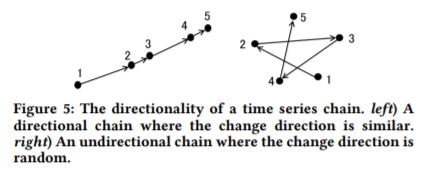

Note: It is worthwhile to note that the authors of G_Chain claim that the reason that the original chain algorithm may find  random spurious chain is that it uses euclidean distance. 

__NOTE:__

One might use DTW (e.g. see [Matrix Profile XXII](https://www.cs.ucr.edu/~eamonn/DTWMotifsSWAMP_Expanded.pdf)), where normalizing the subsequences are allowed, and then find the chains using the chain algorithm proposed in [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf).

## Retrieve the Data

In [132]:
fzip = ZipFile(io.BytesIO(urlopen("https://sites.google.com/site/timeserieschains/materials/GeometricalTSC_ver_04.zip?attredirects=0&d=1").read()))


#damped_sine time series
mat = fzip.extract("GeometricalTSC/data/significance_1_synth/damped_sine.mat")
data = loadmat(mat)
ts_damped_sine = data['Data'].reshape(-1,)

#sine_with_noise time series
mat = fzip.extract("GeometricalTSC/data/significance_1_synth/sine_with_noise.mat")
data = loadmat(mat)
ts_sine_with_noise = data['Data'].reshape(-1,)

## Visualizing the Data

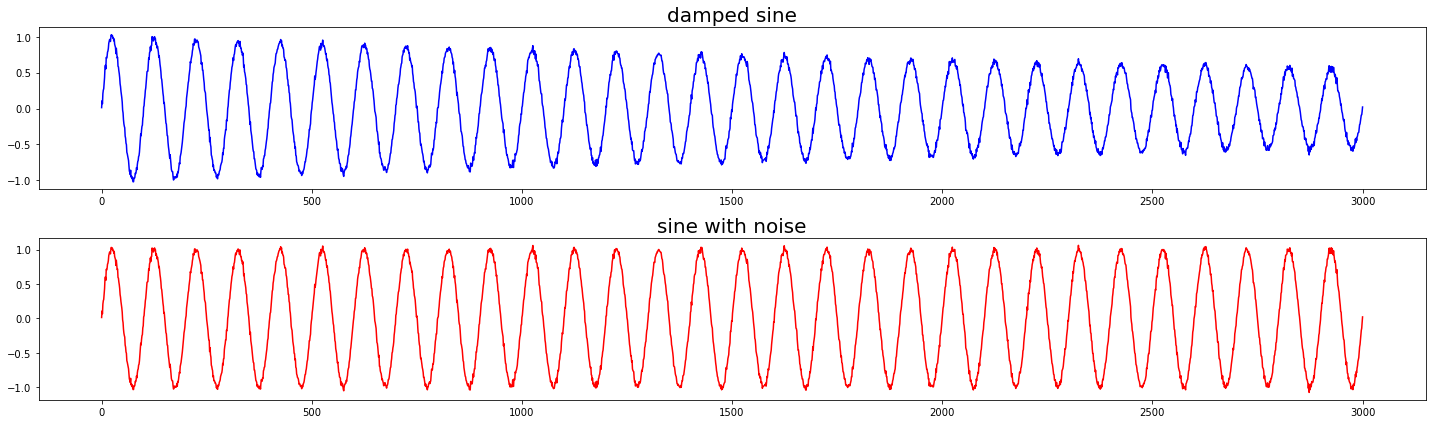

In [133]:
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].set_title('damped sine', fontsize=20)
ax[0].plot(ts_damped_sine, color='b')

ax[1].set_title('sine with noise', fontsize=20)
ax[1].plot(ts_sine_with_noise, color='r')

fig.tight_layout()

Now, let's first implement the algorithm proposed in [Matrix Profile XXI](https://dl.acm.org/doi/abs/10.1145/3394486.3403164)

## Implementing the G_Chain algorithm

The authors suggest that: "a backward chain is a candidate of more robust definition of time series chains. However, a backward chain may still drift to a less similar subsequence. Therefore, we introduce two constraints direction angle and significance score to prevent a chain from drifting to a less similar subsequence."



### >> Unit Vector Function:
To calculate the unit vector being used in the DirectionAngular function

In [119]:
def unit_vector(oneD_ts):
    """
    Compute the unit vector
    
    Parameters
    ----------
    oneD_ts : one-dimentional array


    Returns
    -------
    out : one-dimentional array
        A vector in the same direction as oneD_ts but with unit length
        
    """
    return (oneD_ts/np.linalg.norm(oneD_ts))

### >> DirectionAngular Function:
To calculate the direction angle of change (Section 4, definition 8 in [Matrix Profile XXI](https://dl.acm.org/doi/abs/10.1145/3394486.3403164))

In [120]:
def DirectionAngular(T_A, m, IL, chain_tail_index, j):
    
    """
    Compute the directional angle 

    Note that since the matrix profile indices, `IL` is pre-computed,
    this function is agnostic to subsequence normalization.

    Parameters
    ----------
    T_A : ndarray
        The time series or sequence for which to compute the matrix profile

    m : int
        Window size
        
    IL : ndarray
        Left matrix profile indices

    chain_tail_index : int
        The index value of the last subsequence in a chain
    
    j: int
        The index value of a subsequence in the chain (j != chain_tail_index)
        

    Returns
    -------
    out : scaler between 0 and pi
        the direction angle for the next candidate of the chain (i.e. a subsequent with index at IL[j])
        Note: The geometric chain considers backward direction, therefore the chain starts at its tail and 
        the next candidate has smaller index. 
            
    Notes
    -----
    `DOI: 10.1145/ 3394486.3403164 <https://dl.acm.org/doi/abs/10.1145/3394486.3403164>`__

    See Definition 8.

    This is the implementation for the DirectionAgular function.
    
    Unlike the original paper's implementation, we've z-normalized each subsequence prior to 
    calculating their difference.
    """
    seq_ref = T_A[chain_tail_index:(chain_tail_index+m)]
    seq_ref=stumpy.core.z_norm(seq_ref)
    
    seq_j = T_A[j:(j+m)]
    seq_j=stumpy.core.z_norm(seq_j)
    
    seq_IL_j = T_A[IL[j]:(IL[j]+m)]
    seq_IL_j=stumpy.core.z_norm(seq_IL_j)
    
    x = unit_vector(seq_j - seq_ref) 
    y = unit_vector(seq_IL_j - seq_ref)
    
    #Due to small numerical error, sometimes the dot product of two normalized vector results in a number out of the range [-1,1]
    dot_product = max(min(np.dot(x,y), 1) , -1)
    
    return ( math.acos(dot_product) )

Now, let's see the values of direction angle for a chain of subsequences that can be obtained from the Time Series Chain proposed in [Matrix Profile VII](https://www.cs.ucr.edu/~eamonn/chains_ICDM.pdf) on sine_with_noise data (period of the sine is 100)

In [142]:
#calculating the matrix profile
T_A=ts_sine_with_noise
m=100

mp = stumpy.stump(T_A,m)

#Left matrix profile indices
IL = mp[:,2]

#Right matrix profile indices
IR = mp[:,3]

ALLC, unanchored_chain = stumpy.allc(IL,IR)

#print("ALLC: \n", ALLC)
#print("=======================================")
#print("unanchored_chain: \n", unanchored_chain)
#print("=======================================")

ALLC=np.array(ALLC, dtype='object')
len_of_chains=np.array([len(x) for x in ALLC])

print('longest chains are: \n')
ALLC[np.ix_(len_of_chains==np.max(len_of_chains))]

longest chains are: 



array([array([  43,  343, 2343, 2643, 2743, 2843], dtype=int64),
       array([  41,  341, 2341, 2641, 2741, 2841], dtype=int64),
       array([  42,  342, 2342, 2642, 2742, 2842], dtype=int64),
       array([  44,  344, 2344, 2644, 2744, 2844], dtype=int64)],
      dtype=object)

The original paper [Matrix Profile XXI](https://dl.acm.org/doi/abs/10.1145/3394486.3403164) showed the values of direction angle for only the last one. We show the values of direction angle for the same chain below:

In [143]:
chain = [44,  344, 2344, 2644, 2744, 2844]

index_lst=[]
DirectionAngle_lst=[]

i_val=1
while i_val<(len(chain)-1):
    val = chain[i_val]
    
    index_lst.append(val)
    
    theta_radian = DirectionAngular(T_A, m, IL, chain[-1], val)
    theta_deg = (theta_radian*180)/(math.pi)
    
    DirectionAngle_lst.append(theta_deg)
    
    i_val += 1


    
df = pd.DataFrame( {'index of subsequence': np.array(index_lst), 'direction angle [degree]': np.array(DirectionAngle_lst)} )
df

,index of subsequence,direction angle [degree]
0,344,48.356913
1,2344,45.141880
2,2644,50.628352
3,2744,49.492804


As we can see here, the results are different than the ones provided in the Table 1 of the paper [Matrix Profile XXI](https://dl.acm.org/doi/abs/10.1145/3394486.3403164). 

The reason for such difference is that the authors normalize the difference of subsequences. But, here in our implementation, we first normalize the subsquences and then take their difference.


__NOTE:__

The authors of the paper used MATLAB where the first index of an array is 1 as opposed to Python where the first index is 0. So, in the paper, the indices shown in the aforementioned table are \[345,2345,2645,2745\].

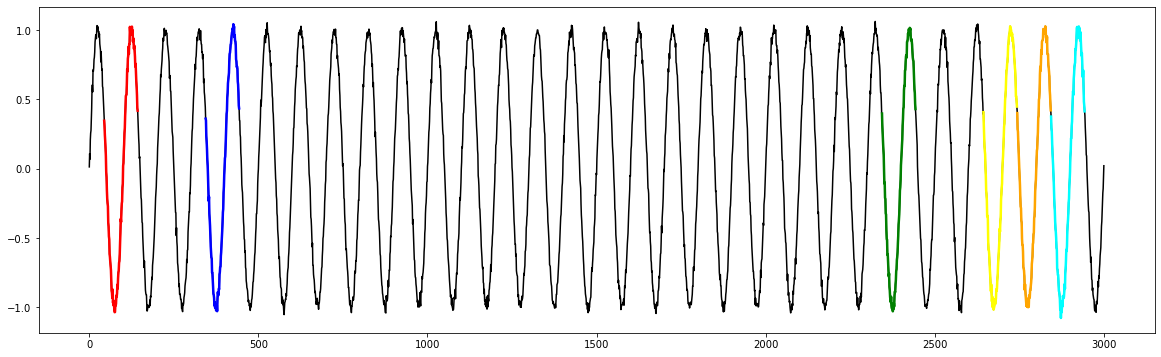

In [153]:
# Plotting time series and chain for sine_with_noise data:

chain = [44,  344, 2344, 2644, 2744, 2844]
T_A = ts_sine_with_noise
m = 100

color_vec = ['r','b','g','yellow','orange','cyan','navy','maroon','m','hotpink','olive']
plt.plot(T_A, 'k')
for i, subseq_index in enumerate(chain):
    plt.plot(np.arange(subseq_index,subseq_index+m), T_A[subseq_index:subseq_index+m], 
             c=color_vec[i], linewidth=2.5)
plt.show()

### >> sig_score Function:
This is to meansure the significance score of a chain. An abrupt changes from one subsequence to the next in the chain penalizes the score. Therefore, higher score indicates that the chain has been changed more naturally. As stated by the authors of the paper: "A higher significance score implies that a chain is more gradually changing"

In [144]:
def sig_score(T_A, m, backward_chain):
    """
    Compute the significance score of a chain 


    Parameters
    ----------
    T_A : ndarray
        The time series or sequence for which to compute the matrix profile

    m : int
        Window size
        
    backward_chain : ndarray
        An array consists of the chain's subsequences' indices, in the descending order 
    

    Returns
    -------
    out : scaler 
        The significance score of the chain
            
    Notes
    -----
    `DOI: 10.1145/ 3394486.3403164 <https://dl.acm.org/doi/abs/10.1145/3394486.3403164>`__

    See Definition 10.

    This is the implementation for the sig_score function. 
    """
    
    
    if len(backward_chain)<=1:
        return -1
    else:
        chain_tail = stumpy.core.z_norm(T_A[backward_chain[0]:(backward_chain[0]+m)]) 
        chain_head = stumpy.core.z_norm(T_A[backward_chain[-1]:(backward_chain[-1]+m)])
        head_tail_diff = np.linalg.norm(chain_tail-chain_head)
        
        
        max_adjacent_diff = -1
        for i in range(1,len(backward_chain)):
            subseq = stumpy.core.z_norm(T_A[backward_chain[i]:(backward_chain[i]+m)])
            previous_subseq = stumpy.core.z_norm(T_A[backward_chain[i-1]:(backward_chain[i-1]+m)])

            max_adjacent_diff = max(max_adjacent_diff, np.linalg.norm(subseq-previous_subseq))


    return (head_tail_diff/max_adjacent_diff)

Previously, we found four chains, each with length 6, from the sine_with_noise data with the help of TSC17. Since it is a bi-directional chain, it can be considered as backward chain. Let's obtain the sig_score value for each of those four chains. 

In [145]:
chains_set = ALLC[np.ix_(len_of_chains==np.max(len_of_chains))]

for chain in chains_set:
    print('chain is: {}, and its sig_score is: {}'.format(chain, sig_score(T_A, m, chain)))
    print('--------------------------------------------------------------------------------')

chain is: [  43  343 2343 2643 2743 2843], and its sig_score is: 1.0686355689827847
--------------------------------------------------------------------------------
chain is: [  41  341 2341 2641 2741 2841], and its sig_score is: 1.068994745184435
--------------------------------------------------------------------------------
chain is: [  42  342 2342 2642 2742 2842], and its sig_score is: 1.0685324371597302
--------------------------------------------------------------------------------
chain is: [  44  344 2344 2644 2744 2844], and its sig_score is: 1.0709381002893807
--------------------------------------------------------------------------------


Here, all the significant scores are close to 1. Therefore, it means the largest change from one subsequence to the next is approximately equal to the change between the subsequences located at the head and the tail of the chain. Therefore, the graduality of the changes in the chain is not meaningful. 

### >>  chain_finder Function:
Now, we can use the DirectionAngular() function to find all the backward chains that satisifies the following condition:

direction angle < THETA, where THETA is a user-defined value. According to the paper, we use THETA=40 as the default value. Since we might need to identify the significant chains out of the discovered ones, we will use sig_score function as well to assign a sig_score to each chain.

In [146]:
def geometric_chain_finder(T_A, m, IL, THETA=40, normalize=True):
    """
    Find all the backward chains in T_A (with minimum length 3), 
    where the direction angle of subsequences is less or equal to THETA.

    Parameters
    ----------
    T_A : ndarray
        numpy array

    m : int
        Window size
        
    
    IL: ndarray
        left matrix profile indices
        
    
    THETA : scaler between 0 and 180
        maximum angle (in degrees) allowed for changes from one subsequent to the next one with respect to the subsequence at chain's tail
        (recommended to be between 30 degree and 50 degree), default: 40 degree
          


    Returns
    -------
    output : dictinary
        dictionary of all chains, where each key corresponds to a chain and it is a dictionary with two keys:
        chain: the indices of the subsequence of the chain (in the descending order)
        sig_score: the sig_score of the chain
    
    
    Notes
    -------
    
    `DOI: 10.1145/ 3394486.3403164 <https://dl.acm.org/doi/abs/10.1145/3394486.3403164>`__

    See Table 4.

    This is the implementation for the ChainFindingAlgorithm.
    """
    THETA_radian = THETA * (math.pi/180)
    
    chains_set_dict = {}
    for i in range(len(IL)):
        chains_set_dict[i] = {}
        if IL[i] >= 0: 
            backward_chain = [i]
            j = IL[i]
            backward_chain.append(j)

            while ((IL[j]>=0) and (DirectionAngular(T_A, m, IL, i, j) <= THETA_radian)):
                backward_chain.append(IL[j])
                j = IL[j]

            
            #print('backward_chain: ', backward_chain)
            if len(backward_chain)<=2:
                del chains_set_dict[i]
                continue
            else:
                chains_set_dict[i]['chain'] = backward_chain
                chains_set_dict[i]['score'] = sig_score(T_A, m, backward_chain)
            
        else:
            del chains_set_dict[i]
            continue
        
            
        
    return chains_set_dict


Let's analyze the sine_with_noise time series data but with the geometric_chain_finder( ) function and see what chains it discovers:

In [155]:
T_A = ts_sine_with_noise
m = 100

mp = stumpy.stump(T_A,m)

#Left matrix profile indices
IL = mp[:,2]


#using geometric approach to find (backward) chains:
Geometric_ALLC = geometric_chain_finder(T_A, m, IL, THETA=40, normalize=True)

print('Chains with Geometric Approach: \n', Geometric_ALLC)

Chains with Geometric Approach: 
 {}


Similar to what claimed in the paper, Geometric Chains discover no chain as it tries to avoid discovering spurious chains.

====================================================

Now, Let's find out what chains we can discover by using the regular approach (TSC17) and by the geometric approach (TSC20):

In [156]:
T_A = ts_damped_sine #Time Seies 
m=100 #window length
mp = stumpy.stump(T_A,m) #matrix profile
IL = mp[:,2] #Left matrix profile indices
IR = mp[:,3] #right matrix profile indices

In [158]:
#Using regular approach (TSC17):
ALLC, unanchored_chain = stumpy.allc(IL,IR)
max_len = len(unanchored_chain)
len_of_chains_from_ALLC = np.array([len(x) for x
                                    in ALLC])
max_len_indices = np.ix_(len_of_chains_from_ALLC==max_len)[0]
print('longest chains using TSC17: \n', [ALLC[x] for x in max_len_indices])


print('-------------------------------------------------------------------')
#Using geometric approach (TSC20):
G_ALLC = geometric_chain_finder(T_A, m, IL, THETA=40, normalize=True)
G_ALLC_keys = list(G_ALLC.keys())

len_of_chains_from_G_ALLC=np.array([len(G_ALLC[x]['chain']) for x in G_ALLC])
max_len = np.max(len_of_chains_from_G_ALLC)
max_len_indices = np.ix_(len_of_chains_from_G_ALLC==max_len)[0]
print('longest chains using TSC20: \n', [G_ALLC[G_ALLC_keys[x]] for x in max_len_indices])

longest chains using TSC17: 
 [array([ 32, 332, 532, 832], dtype=int64), array([  55,  355, 1255, 1655], dtype=int64), array([  57,  357, 1257, 1657], dtype=int64), array([  56,  356, 1256, 1656], dtype=int64), array([ 26, 126, 526, 826], dtype=int64), array([ 31, 331, 531, 831], dtype=int64), array([ 25, 125, 525, 825], dtype=int64), array([  54,  354, 1254, 1654], dtype=int64), array([ 29, 329, 529, 829], dtype=int64), array([  47,  347, 1247, 1647], dtype=int64), array([  53,  353, 1253, 1653], dtype=int64), array([ 264,  464,  664, 1064], dtype=int64), array([ 20, 420, 520, 820], dtype=int64)]
-------------------------------------------------------------------
longest chains using TSC20: 
 [{'chain': [2503, 403, 103, 3], 'score': 1.1107560617445154}]


==============================================================

In contrast to what presented in the paper, the longest chain that can be discovered with the "revised" Geometric Approach has the length of 4. The reason is that instead of z-normalizing the subsequences prior to calculating their difference, the authors first take the difference of two subsequences and then z-normalize it. Although their implementation will result in chain with 7 subsequences, the implementation provided here achieve 4-subsequence chain as the longest chain. 

Furthermore, TSC17 can find more chains of length 4 while the geometric approach finds only one. 

==============================================================

It is worthwhile to calculate the sig_score of the 4-subsequence chains achieved by the TSC17 (regular approach) and compare it with sig_score of the geometric approach:

In [150]:
ALLC, unanchored_chain = stumpy.allc(IL,IR)
max_len = len(unanchored_chain)
len_of_chains_from_ALLC = np.array([len(x) for x
                                    in ALLC])
max_len_indices = np.ix_(len_of_chains_from_ALLC==max_len)[0]
ALLC_longest_chains = [ALLC[x] for x in max_len_indices]
for chain in ALLC_longest_chains:
    print('>>> chain={}, with sig_score={}'.format(chain[::-1], sig_score(T_A,m,chain[::-1]) ))
    print('----------------------------------------------------------------------------------')

>>> chain=[832 532 332  32], with sig_score=1.1724840912124017
----------------------------------------------------------------------------------
>>> chain=[1655 1255  355   55], with sig_score=1.1141756133179717
----------------------------------------------------------------------------------
>>> chain=[1657 1257  357   57], with sig_score=1.1026402136720959
----------------------------------------------------------------------------------
>>> chain=[1656 1256  356   56], with sig_score=1.1106644484552235
----------------------------------------------------------------------------------
>>> chain=[826 526 126  26], with sig_score=1.1538023941830895
----------------------------------------------------------------------------------
>>> chain=[831 531 331  31], with sig_score=1.178489773635271
----------------------------------------------------------------------------------
>>> chain=[825 525 125  25], with sig_score=1.164998326064273
---------------------------------------------------

As one can notice from the sig_score of bi-directional chains achieved by TSC17, there are chains with sig_score higher than the one achieved by the TSC20 (geometric approach) and there are some with sig_score values lower than the one achieved by the TSC20. 

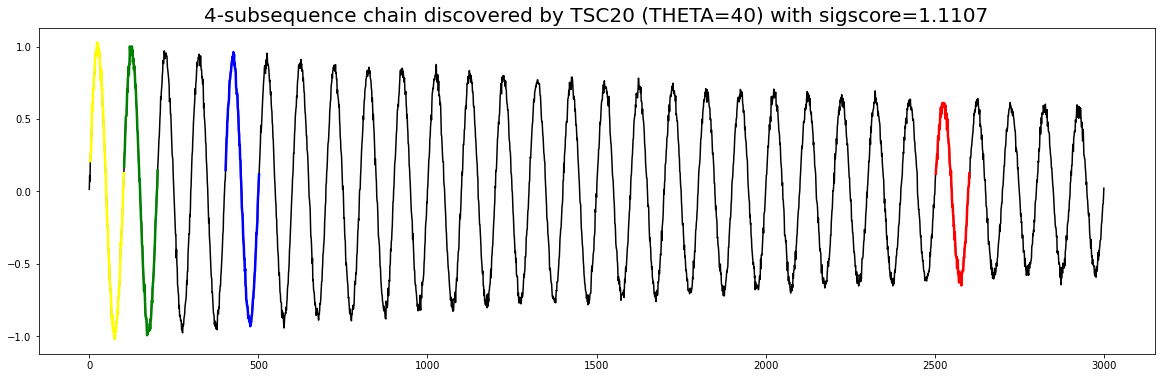

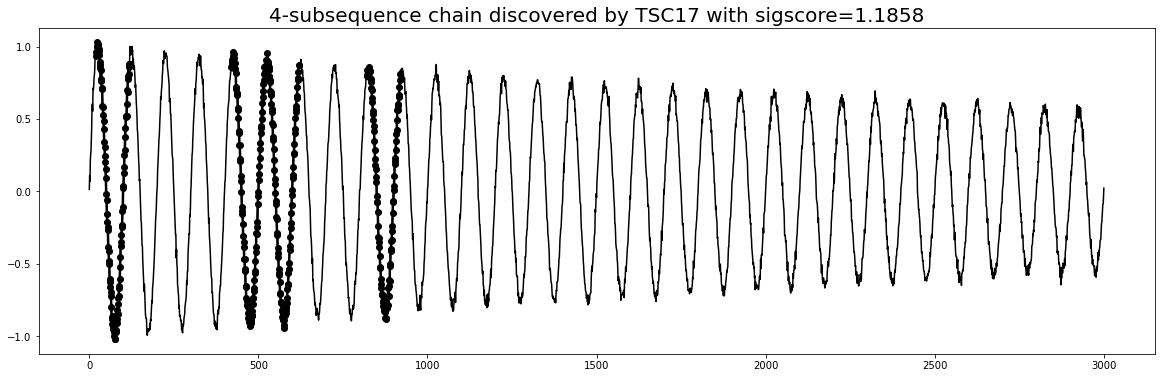

In [183]:
# Plotting time series and chain for damped_sine_with_noise data:

chain_TSC20 = [2503, 403, 103, 3]# This is chain is discovered by the geometric approach using THETA=40
chain_TSC17 = [820, 520, 420,  20]# This is chain is discovered by the regular approach and has the highest sig_score

T_A = ts_damped_sine
m = 100

color_vec = ['r','b','g','yellow','orange','cyan','navy','maroon','m','hotpink','olive']
plt.title('4-subsequence chain discovered by TSC20 (THETA=40) with sigscore=1.1107' ,fontsize=20)
plt.plot(T_A, 'k')
for i, subseq_index in enumerate(chain_TSC20):
    plt.plot(np.arange(subseq_index,subseq_index+m), T_A[subseq_index:subseq_index+m], 
             c=color_vec[i], linewidth=2.5)

plt.show()



plt.title('4-subsequence chain discovered by TSC17 with sigscore=1.1858',fontsize=20)
plt.plot(T_A, 'k')
for i, subseq_index in enumerate(chain_TSC17):
    plt.plot(np.arange(subseq_index,subseq_index+m), T_A[subseq_index:subseq_index+m], 
             c='k', marker='o', linewidth=2.5)
        
plt.show()

In [179]:
# Plotting time series and chain for damped_sine_with_noise data:
# This is chain is discovered by the geometric approach using THETA=50


G_ALLC = geometric_chain_finder(T_A, m, IL, THETA=50, normalize=True)
G_ALLC_keys = list(G_ALLC.keys())

len_of_chains_from_G_ALLC=np.array([len(G_ALLC[x]['chain']) for x in G_ALLC])
max_len = np.max(len_of_chains_from_G_ALLC)
max_len_indices = np.ix_(len_of_chains_from_G_ALLC==max_len)[0]
print('longest chains using TSC20: \n', [G_ALLC[G_ALLC_keys[x]] for x in max_len_indices])

longest chains using TSC20: 
 [{'chain': [2464, 1064, 664, 464, 264, 164, 64], 'score': 1.1966598372935997}, {'chain': [2466, 1066, 666, 466, 266, 166, 66], 'score': 1.1742333684991}, {'chain': [2467, 1067, 667, 467, 267, 167, 67], 'score': 1.1583350604765728}]


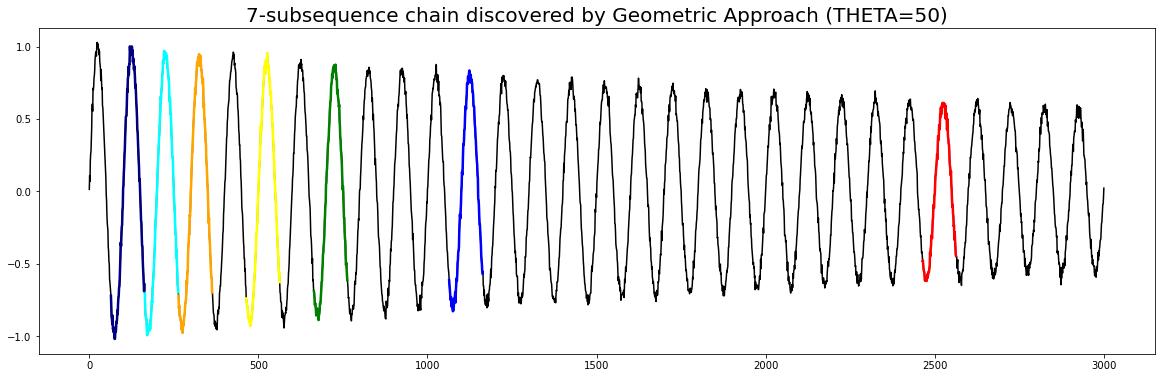

In [180]:
chain = [2464, 1064, 664, 464, 264, 164, 64]    #longest chain (discovered by geometric appproch and THETA=40) 
                                                #with highest sig_score
T_A = ts_damped_sine
m = 100

color_vec = ['r','b','g','yellow','orange','cyan','navy','maroon','m','hotpink','olive']
plt.plot(T_A, 'k')

plt.title('7-subsequence chain discovered by Geometric Approach (THETA=50)',fontsize=20)
for i, subseq_index in enumerate(chain):
    plt.plot(np.arange(subseq_index,subseq_index+m), T_A[subseq_index:subseq_index+m], 
             c=color_vec[i], linewidth=2.5)
plt.show()